In [20]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tracker.tank import Tank
import tracker.utils as utils
from collections import defaultdict

tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8, 43:33.8 }
tank_radius_vs_age = { k:v/2 for k,v in tank_diameter_vs_age.items() }
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 9,6

# Load trials

In [2]:
''' Select a set of trials to analyze. '''

# trial_files = sorted(glob('../tracking/full_20-07-19/*/trial.pik')) # [:1]
# trial_files = ['../tracking/full_20-09-25/Pa_Fri_14dpf_GroupA_n2b_20200612_1400/trial.pik']
# trial_files = ['../tracking/test_21-01-02/SF_Sat_70dpf_GroupA_n5_20200808_1015/trial.pik']
trial_files = sorted(glob('../tracking/test_21-01-03/*/trial.pik')) # [:1]


def load_trial(trial_file,load_data=True):
    trial_dir  = os.path.dirname(trial_file)
    fig_dir    = os.path.join(trial_dir,'figures')
    trial_name = os.path.basename(trial_dir)
    pop,day,age,group,n_ind = trial_name.split('_')[:5]
    age        = int(age[:-3])
    n_ind      = int(re.findall('\d+',n_ind)[0])
    trial      = { k:v for k,v in locals().items() if k in ['trial_dir', 
                   'fig_dir', 'trial_name', 'pop', 'age', 'group', 'n_ind'] }
    trial['R_cm'] = tank_radius_vs_age.get(age,np.nan)
    
    if load_data:
        trial.update(utils.load_pik(trial_file))
        ellipse = cv2.fitEllipse(trial['tank']['contour'])
        trial['center'] = np.array(ellipse[0])
        trial['R_px']   = np.mean(ellipse[1])/2
        
    return trial


''' Count trials of each type. '''
trials = [load_trial(f,load_data=False) for f in trial_files]
df     = pd.DataFrame(trials,index=trial_files)
grouped_trials = df.groupby(['pop','age','n_ind'])
count  = pd.DataFrame(grouped_trials['trial_dir'].count().rename('count'))
count

count
pop age n_ind       
Pa  7   5          1
    14  5          1
    21  5          1
    28  5          1
    70  5          1
    84  5          1
SF  7   5          1
    14  5          1
    21  5          1
    28  5          1
    70  5          1

# Area and aspect ratio distributions

This is useful to optimize the tracking algorithm's area and aspect ratio constraints.

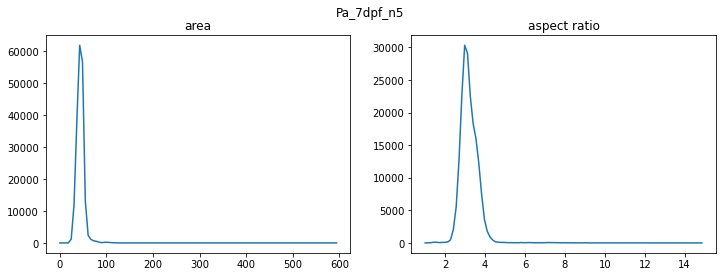

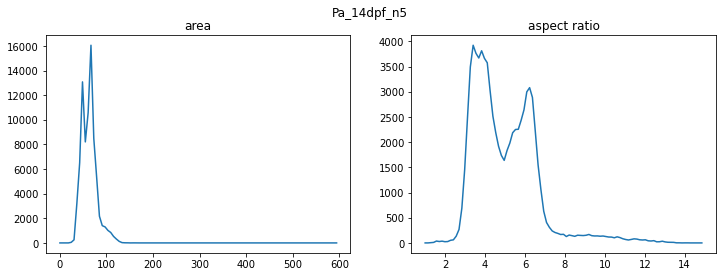

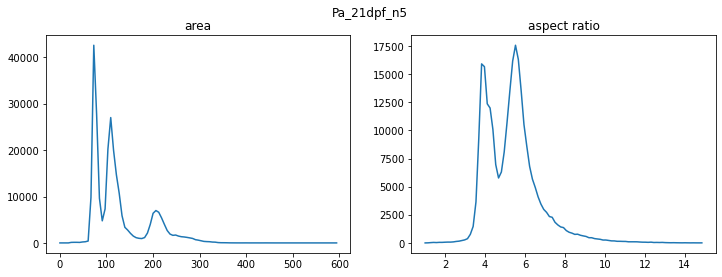

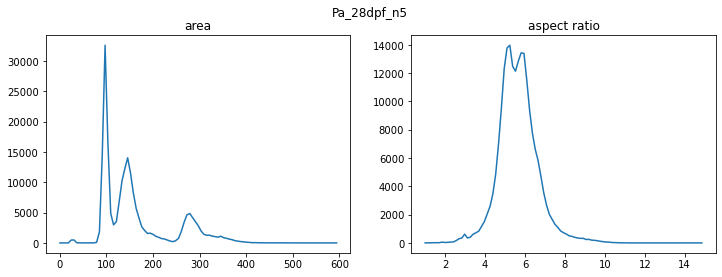

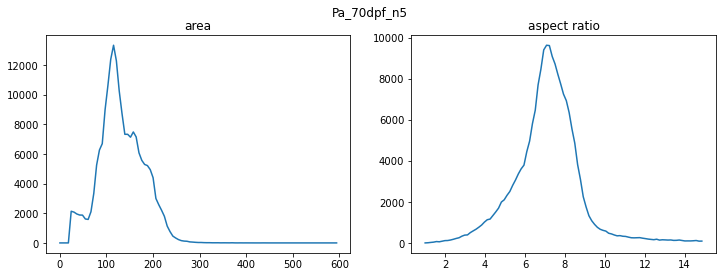

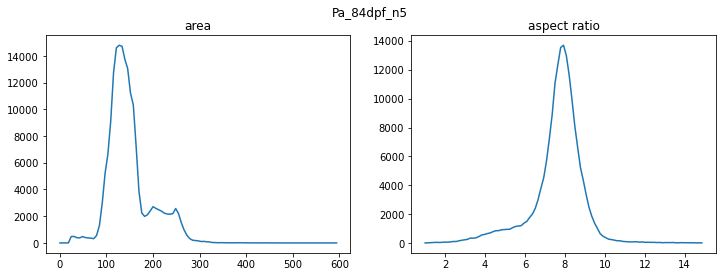

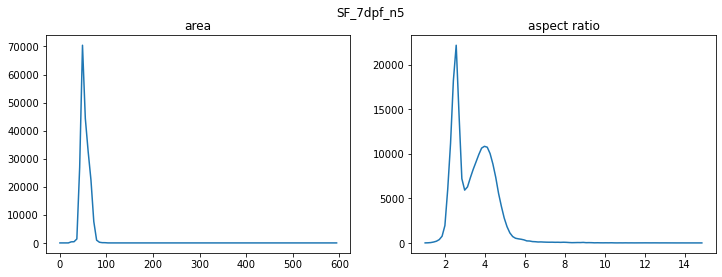

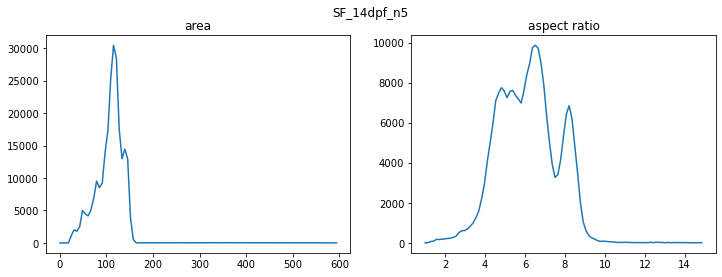

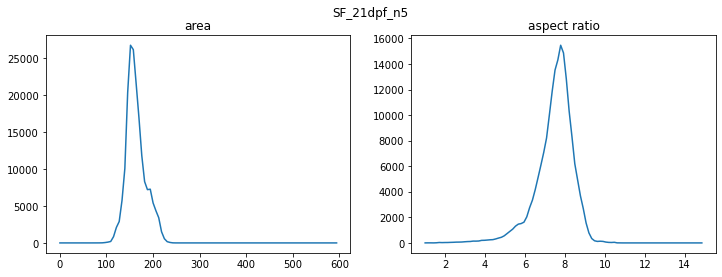

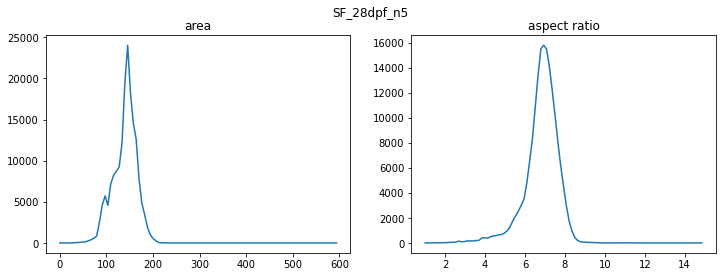

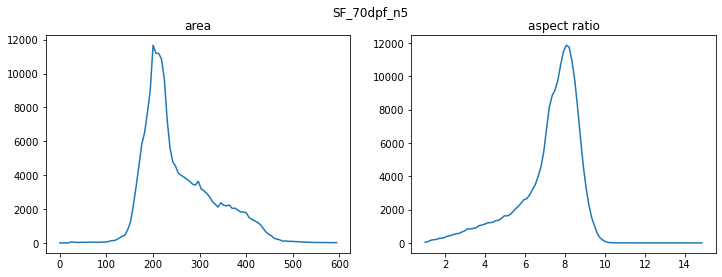

In [3]:
# display(df)

# area bins, then aspect ratio bins
B = [np.linspace(0,600,100), np.linspace(1,15,100)]

for g,files in grouped_trials.groups.items():
    H  = [ np.zeros(len(b)-1) for b in B ]
    for f in files:
        trial = load_trial(f)
        for i,j in enumerate([3,4]):
            h,_ = np.histogram(trial['data'][:,:,j],bins=B[i])
            H[i] += h
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    fig.suptitle(f'{g[0]}_{g[1]}dpf_n{g[2]}')
    for i in range(2):
        ax[i].plot(B[i][:-1],H[i])
        ax[i].set_title(['area','aspect ratio'][i])
    plt.show()

# Kinematics and cuts


*TODO*? Use an "acclimation cut" (dismiss the first xx minutes).

In [4]:
def dist2ellipse(semi_major, semi_minor, xy):
    px,py = np.absolute(xy)
    tx,ty = 0.707,0.707
    a = semi_major
    b = semi_minor
    for x in range(0, 3):
        x   = a * tx
        y   = b * ty
        ex  = (a*a - b*b) * tx**3 / a
        ey  = (b*b - a*a) * ty**3 / b
        rx  = x - ex
        ry  = y - ey
        qx  = px - ex
        qy  = py - ey
        r   = np.hypot(ry, rx)
        q   = np.hypot(qy, qx)
        tx  = min(1, max(0, (qx * r / q + ex) / a))
        ty  = min(1, max(0, (qy * r / q + ey) / b))
        t   = np.hypot(ty, tx)
        tx /= t 
        ty /= t 
    return (np.copysign(a * tx, xy[0]), np.copysign(b * ty, xy[1]))    


def compute_kinematics(trial,wall_distance=False):
    center  = trial['center']
    px2cm   = trial['R_cm']/trial['R_px']
    
    n           = trial['n_ind']
    pos         = trial['data'][:,:n,:3].copy() # discard extra objects
    pos[:,:,:2] = (pos[:,:,:2]-center[None,None,:])*px2cm # convert to centimeters
    pos[:,:,1]  = -pos[:,:,1] # flip y axis
    for j in range(n): # unwrap orientations
        I          = ~np.isnan(pos[:,j,2])
        pos[I,j,2] = np.unwrap(pos[I,j,2])
    
    time = trial['frame_list']/trial['fps']
    vel  = np.gradient(pos,time,axis=0)
    acc  = np.gradient(vel,time,axis=0)
    v    = np.hypot(vel[:,:,0],vel[:,:,1])
    
    d_wall = trial['R_cm'] - np.hypot(pos[:,:,0],pos[:,:,1])
# #     dist    = lambda xy: dist2ellipse(*ellipse[1],xy)
#     dist    = lambda xy: cv2.pointPolygonTest(trial['tank']['contour'],tuple(xy),True)
#     d_wall  = px2cm * np.apply_along_axis(dist,2,trial['data'][:,:,:2])
    
    trial.update({ k:v for k,v in locals().items() if k in 
                   ['time', 'pos', 'vel', 'acc', 'd_wall', 'v'] })
    return trial


def compute_cuts(trial):
    globals().update(trial)
    R = np.inf
    ranges = { 'd_wall':[-0.1*R,R], 'v':[0,np.inf], 'v_ang':[-np.inf,np.inf] }
    cut_label = ', '.join([ f'{v[0]}<={k}<={v[1]}' for k,v in ranges.items() ])
    
    # valid array: axis 0 = time, axis 1 = [nan_xy,nan_any,d_wall,v,v_ang,final]
    valid  = np.full(pos.shape[:2]+(7,),np.True_,dtype=np.bool_)
    valid[:,:,0] = np.logical_not(np.any(np.isnan(pos),axis=2))
    valid[:,:,1] = np.logical_not(np.any(np.isnan(vel),axis=2))
    valid[:,:,2] = np.logical_not(np.any(np.isnan(acc),axis=2))
    valid[:,:,3] = np.logical_and(d_wall>=ranges['d_wall'][0],d_wall<=ranges['d_wall'][1])
    valid[:,:,4] = np.logical_and(v>=ranges['v'][0],v<=ranges['v'][1])
    valid[:,:,5] = np.logical_and(vel[:,:,2]>=ranges['v_ang'][0],vel[:,:,2]<=ranges['v_ang'][1])
    valid[:,:,6] = np.all(valid[:,:,:5],axis=1)
    
    n_total = valid.shape[0]*valid.shape[1]
    n_valid = np.count_nonzero(valid,axis=(0,1))
    valid_fraction = { 'nan_pos' : n_valid[0]/n_total, 
                       'nan_vel' : n_valid[1]/n_total, 
                       'nan_acc' : n_valid[2]/n_total, 
                       'd_wall'  : n_valid[3]/n_valid[0], 
                       'v'       : n_valid[4]/n_valid[1], 
                       'v_ang'   : n_valid[5]/n_valid[1], 
                       'final'   : n_valid[6]/n_total     }
    
    trial.update({'valid':valid, 'valid_fraction':valid_fraction, 'cut_label':cut_label})
    return trial


t0 = datetime.datetime.now()

trial = load_trial(trial_files[0], load_data=True)
trial = compute_kinematics(trial)
trial = compute_cuts(trial)

print(datetime.datetime.now()-t0)

0:00:00.021023


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal


In [5]:
# trial = load_trial(trial_files[0])
# trial = compute_kinematics(trial)
# trial = compute_cuts(trial)
# locals().update(trial)

# plt.figure(figsize=(8,)*2)
# plt.plot(*np.moveaxis(pos[::5,:,:2],2,0),lw=0.5)
# circle = plt.Circle((0,0), R_cm, facecolor='None', edgecolor='k', lw=0.5)
# plt.gca().add_patch(circle)
# plt.axis('equal')
# plt.show()

# d = d_wall.flatten()
# d = d[np.isfinite(d)]
# plt.hist(d,bins=50)
# plt.show()

# Plot

### Dynamics

In [6]:
for trial_file in trial_files:
#     print(trial_file)
    trial = load_trial(trial_file, load_data=True)
    trial = compute_kinematics(trial)
    locals().update(trial)
    
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    
    # Trajectories.
    plt.figure(figsize=(6,)*2)
    plt.gca().add_patch(plt.Circle(center, R_px, facecolor='None', 
                                   edgecolor='k', lw=0.5))
    plt.plot(*np.moveaxis(data[::5,:n_ind,:2],2,0),lw=0.5)
    plt.axis('equal')
    plt.gca().yaxis.set_inverted(True)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'trajectories.png'))
    plt.close()
    
    # Angle vs time.
    plt.figure(figsize=(12,6))
    plt.plot(time[:,None],pos[:,:,2])
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'angle-vs-time.png'))
    plt.close()

### Statistics

In [7]:
for trial_file in trial_files:
#     print(trial_file)
    trial = load_trial(trial_file, load_data=True)
    trial = compute_kinematics(trial)
    trial = compute_cuts(trial)
    locals().update(trial)
    
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    
    # Valid fraction.
    bp = plt.bar(*zip(*valid_fraction.items()))
    for bar in bp:
        h,x,w = bar.get_height(),bar.get_x(),bar.get_width()
        plt.annotate(f'{h:.2f}', xy=(x+w/2,1.01), ha='center', va='bottom')
    plt.ylim(0,1.1)
    plt.ylabel('Valid fraction')
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'valid_fraction.png'))
    plt.close()
    
    # Distribution of distance to the wall.
#     bins = np.linspace(-0.1*R_cm,R_cm,30)
    values = d_wall.flatten()
    plt.hist(values[~np.isnan(values)],bins=30)
    plt.xlabel(f'd_wall (cm)')
    plt.ylabel('frequency')
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'd_wall-histogram.png'))
    plt.close()
    
    # Speed distribution.
    values = v.flatten()
    plt.hist(values[~np.isnan(values)],bins=30)
    plt.xlabel(f'v (cm/s)')
    plt.ylabel('frequency')
    plt.yscale('log')
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'v-histogram.png'))
    plt.close()
    
    # Angular speed distribution.
    values = vel[:,:,2].flatten()
    plt.hist(values[~np.isnan(values)],bins=30)
    plt.xlabel(f'v_ang (rad/s)')
    plt.ylabel('frequency')
    plt.yscale('log')
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'v_ang-histogram.png'))
    plt.close()
    

/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/i

In [8]:
# ''' Analyze instances of unusually high velocity. '''

# # At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# # corresponds to about pi/3 in one frame.
# print('v_ang for pi/3 in (1/30) second:',np.pi/3*fps)

# print('Instances of unusually high v_ang:')
# for f in fish_list:
#     ang_diff  = df[f,'ang'].diff()
#     I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
#     for i in I[:5]:
#         display(df[f,'ang'].iloc[i-1:i+2])

### Joint pair distance-pair angle distribution

In [9]:
for trial_file in trial_files:
    print(trial_file)
    trial = load_trial(trial_file, load_data=True)
    if trial['n_ind']<2 or np.isnan(trial['R_cm']):
        continue
    trial = compute_kinematics(trial)
    trial = compute_cuts(trial)
    locals().update(trial)
    
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    
    bins_d  = np.linspace(0,2*R_cm,15) # pair distance bins for 2d histogram
    bins_a  = np.linspace(0,np.pi,15)  # pair angle bins for 2d histogram
    bins_d2 = np.linspace(0,2*R_cm,30) # pair distance bins for polar OP vs distance
    J1,J2 = np.triu_indices(n_ind,1)
    d     = np.hypot(pos[:,J1,0]-pos[:,J2,0],pos[:,J1,1]-pos[:,J2,1]).flatten()
    a     = (pos[:,J1,2]-pos[:,J2,2]).flatten()
    a     = a - 2*np.pi*np.rint(a/(2*np.pi))
    I     = np.logical_not(np.logical_or(np.isnan(d),np.isnan(a)))
    d     = d[I]
    a     = a[I]
    
    h,_,_ = np.histogram2d(d, np.absolute(a), bins=(bins_d,bins_a), normed=True)
    plt.pcolormesh(bins_d, bins_a*180/np.pi, h.T, cmap='Oranges')
    plt.xlabel('pair distance (cm)')
    plt.ylabel('pair angle (deg)')
    plt.colorbar()
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'distance-angle_2d-histogram.png'))
    plt.close()
    
    b = bins_d2
    K = np.digitize(d,b)
    p = np.array([ np.mean(np.cos(a[K==i])) for i in range(len(b)+1) ])
    plt.plot((b[1:]+b[:-1])/2,p[1:-1],marker='o',mfc='None',ms=4)
    plt.xlabel('pair distance (cm)')
    plt.ylabel('mean cosine of pair angle')
    plt.ylim(-1,1)
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'polar-order-vs-distance.png'))
    plt.close()
    

../tracking/test_21-01-03/Pa_Fri_14dpf_groupA_n5_20200612_1300_10FPS/trial.pik
../tracking/test_21-01-03/Pa_Fri_21dpf_GroupA_n5_20200619_1345/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yaouen/software/min

../tracking/test_21-01-03/Pa_Fri_28dpf_groupA_n5_20200626_1800/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


../tracking/test_21-01-03/Pa_Fri_7dpf_GroupA_n5_20200605_1100/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


../tracking/test_21-01-03/Pa_Fri_84dpf_GroupA_n5_20200821_1304/trial.pik
../tracking/test_21-01-03/Pa_fri_70dpf_GroupA_n5_20200807_1600/trial.pik
../tracking/test_21-01-03/SF_Sat_14dpf_GroupA_n5_20200613_1205/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


../tracking/test_21-01-03/SF_Sat_21dpf_GroupA_n5_20200620_1530/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal


../tracking/test_21-01-03/SF_Sat_28dpf_GroupA_n5_20200627_1340/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal


../tracking/test_21-01-03/SF_Sat_70dpf_GroupA_n5_20200808_1015/trial.pik
../tracking/test_21-01-03/SF_Sat_7dpf_GroupA_n5_20200606_1200/trial.pik


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
# plt.close('all')

# Aggregate

### Valid fraction

In [26]:
grouped_valid_fractions = {}
for g,files in grouped_trials.groups.items():
    grouped_valid_fractions[g] = defaultdict(list)
    for f in files:
        trial = load_trial(f)
        trial = compute_kinematics(trial)
        trial = compute_cuts(trial)
        locals().update(trial)
        for cut,vf in trial['valid_fraction'].items():
            grouped_valid_fractions[g][cut].append(vf)
# grouped_valid_fractions

/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less_equal
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in long_scalars
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in long_scalars
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/i

('Pa', 7, 5)


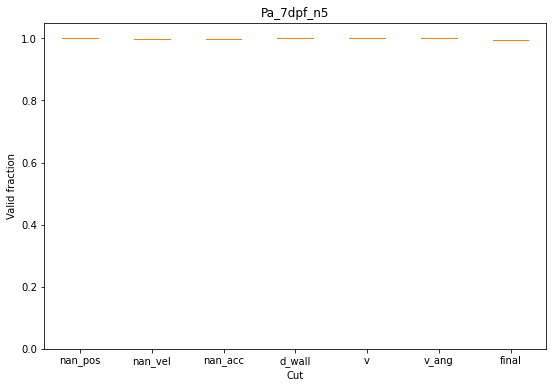

In [25]:
for k,valid_fractions in grouped_valid_fractions.items():
    print(k)
    plt.boxplot(valid_fractions.values(),labels=valid_fractions.keys())
#     plt.violinplot([valid_fractions[c] for c in cut_names],showextrema=False)
    plt.xlabel('Cut')
    plt.ylabel('Valid fraction')
    plt.ylim(0,1.05)
    pop,age,n_ind = k
    name = f'{pop}_{age}dpf_n{n_ind}'
    plt.title(name)
    plt.show()
#     plt.savefig(os.path.join(fig_dir,name+'.png'))
#     plt.close()
    break

# Clean up

In [11]:
# for trial_file,trial in trials.items():
#     locals().update(trial)
    
#     # Delete figure directory and its contents.
# #     os.remove(fig_dir)
    